In [1]:
import pandas as pd 

In [2]:
df = pd.read_csv(r"C:\Users\Rohan\Pictures\rohan\csv. file\IMDB Dataset.csv")

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.shape

(49582, 2)

In [5]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [6]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Remove HTML tags, '&', '?' and punctuation
    text = re.sub(r'<[^>]*>|[&?]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lowercasing
    text = text.lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing punctuation and non-alphanumeric characters
    tokens = [word for word in tokens if word.isalnum() or word in ['!', '?']]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Joining tokens back into a single string
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text


In [7]:
a=  df.review[10520]
a

'A slow, tedious, and one dimensional movie! Good casting with clichéd dialogue, boring story line, and soulless direction from Mr Marshal! The conventional and predictable story of the most famous form of prostitution from the Asian continent, lacks heart, new insights, and depth. The lead character looks out of place due to her tiny phisique and phony looking contact lenses. The lexicon employed by the geishas sounds forced and a bit too sophisticated for their limited exposure in the ways of education. The story goes on and on for hours trying to convince you this little, boring, flat chested Asian girl is the ultimate Geisha, they actually say in the movie "She is destined to become a legend" i say hardy the case! The movie is just plain boring, it is beautiful to look at, it has a very few interesting moments as many as you may find by going out for cigarretes. Basically, if you don\'t believe the messenger you wont believe the message, and this girl didn\'t fill the shoe! Borin, 

In [8]:
preprocess_text(a)

'slow tedious one dimensional movie good casting clichéd dialogue boring story line soulless direction mr marshal conventional predictable story famous form prostitution asian continent lack heart new insight depth lead character look place due tiny phisique phony looking contact lens lexicon employed geisha sound forced bit sophisticated limited exposure way education story go hour trying convince little boring flat chested asian girl ultimate geisha actually say movie destined become legend say hardy case movie plain boring beautiful look interesting moment many may find going cigarretes basically dont believe messenger wont believe message girl didnt fill shoe borin boring skip'

In [9]:
df['preprocessed_review'] = df['review'].apply(preprocess_text)

In [10]:
df.head()

,review,sentiment,preprocessed_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching 1 oz episode y...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


In [11]:
df.sentiment.value_counts()

sentiment
positive    24884
negative    24698
Name: count, dtype: int64

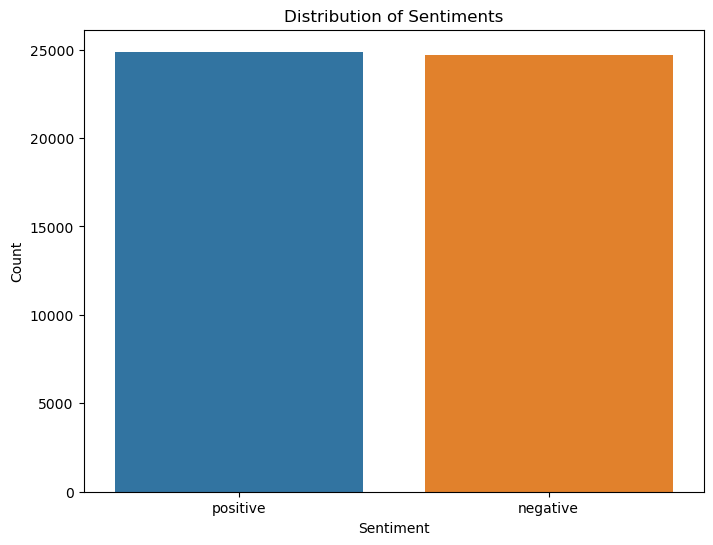

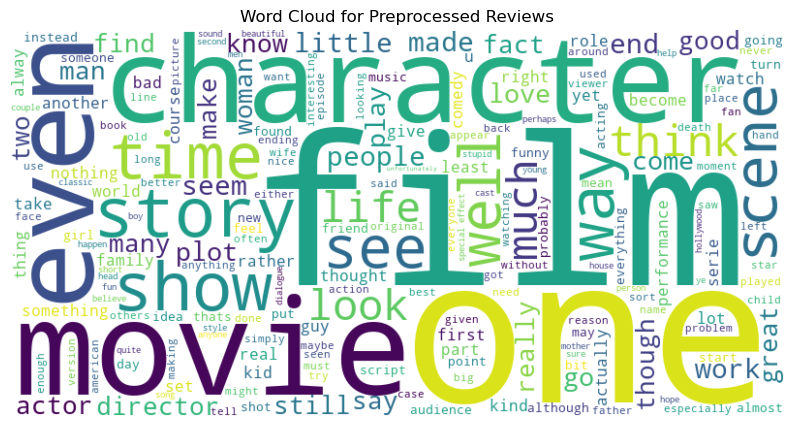

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

from wordcloud import WordCloud
all_text = ' '.join(df['preprocessed_review'].values)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Preprocessed Reviews')
plt.axis('off')
plt.show()


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['sentiment'], test_size=0.2, random_state=42)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=43000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

print("Classification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))


Training Accuracy: 0.9297365435522501
Testing Accuracy: 0.8929111626499949
Classification Report for Testing Set:
              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4939
    positive       0.88      0.91      0.89      4978

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [82]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Define a pipeline with TfidfVectorizer and LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Define parameters grid for GridSearchCV
param_grid = {
    'tfidf__max_features': [ 20000,10000]  # Adjust the list of values as needed
}

# Perform grid search
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Parameters: {'tfidf__max_features': 20000}
Best Score: 0.8915668725576706


In [78]:
def predict_sentiment(user_input, tfidf_vectorizer, model):
    preprocessed_input = preprocess_text(user_input)
    input_tfidf = tfidf_vectorizer.transform([preprocessed_input])
    user_prediction = model.predict(input_tfidf)[0]
    return user_prediction

user_input = 'i love this movie'
predicted_sentiment = predict_sentiment(user_input, tfidf_vectorizer, model)
print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: positive


In [79]:
df.iloc[21789]

review                 If you would like to see a film of different k...
sentiment                                                       positive
preprocessed_review    would like see film different kind feel love h...
Name: 21872, dtype: object

In [ ]:
df.review[21789]

In [80]:
user_input = input('')
predicted_sentiment = predict_sentiment(user_input, tfidf_vectorizer, model)
print("Predicted Sentiment:", predicted_sentiment)

i love movie
Predicted Sentiment: positive


In [93]:
import pickle
pickle.dump(model, open('D:\\git hub upload project\\rf_model.pkl', 'wb')) 
pickle.dump(tfidf_vectorizer, open('D:\\git hub upload project\\tfidf_vectorizer.pkl', 'wb')) 

In [94]:
import pickle

with open('D:\\git hub upload project\\rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('D:\\git hub upload project\\tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

In [96]:
user_input = input('')
predicted_sentiment = predict_sentiment(user_input, tfidf, rf)
print("Predicted Sentiment:", predicted_sentiment)

i love movie
Predicted Sentiment: positive


In [39]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess your dataset
# Assume 'text' is a column containing preprocessed text reviews and 'sentiment' is the corresponding sentiment label column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['sentiment'], test_size=0.2, random_state=42)

# CountVectorizer
count_vectorizer = CountVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_count, y_train)

# Predict sentiment on the training set
y_train_pred = model.predict(X_train_count)
# Predict sentiment on the test set
y_test_pred = model.predict(X_test_count)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

print("Classification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))


C:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.9724190092020674
Testing Accuracy: 0.8671977412523949
Classification Report for Testing Set:
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4939
    positive       0.86      0.87      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load and preprocess your dataset
# Assume 'text' is a column containing preprocessed text reviews and 'sentiment' is the corresponding sentiment label column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['preprocessed_review'], df['sentiment'], test_size=0.2, random_state=42)

# CountVectorizer for Bag-of-Words representation
count_vectorizer = CountVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train_bow, y_train)

# Predict sentiment on the training set
y_train_pred = model.predict(X_train_bow)
# Predict sentiment on the test set
y_test_pred = model.predict(X_test_bow)

# Calculate training and testing accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)

print("Classification Report for Testing Set:")
print(classification_report(y_test, y_test_pred))


C:\Users\Rohan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.9724190092020674
Testing Accuracy: 0.8671977412523949
Classification Report for Testing Set:
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      4939
    positive       0.86      0.87      0.87      4978

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



In [52]:
def predict_sentiment(user_input, count_vectorizer, model):
    preprocessed_input = preprocess_text(user_input)
    input_bow = count_vectorizer.transform([preprocessed_input])
    user_prediction = model.predict(input_bow)[0]
    return user_prediction

user_input = aa
predicted_sentiment = predict_sentiment(user_input, count_vectorizer, model)
print("Predicted Sentiment:", predicted_sentiment)

Predicted Sentiment: positive


In [47]:
df.sample(4)

,review,sentiment,preprocessed_review
45075,I'm not going to lie and say I don't watch the...,negative,im going lie say dont watch showi lot lot flaw...
18163,Dana Andrews is one of those actors that I've ...,positive,dana andrew one actor ive probably seen dozen ...
33546,OZ is an old TV series released by HBO. It sho...,positive,oz old tv series released hbo show life one se...
21989,"I don't usually watch Hollywood dribble, but I...",negative,dont usually watch hollywood dribble dragged a...


In [54]:
aa = df.preprocessed_review[21989]

In [ ]:
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle

with open('D:\\git hub upload project\\rf_model.pkl', 'rb') as f:
    rf = pickle.load(f)
with open('D:\\git hub upload project\\tfidf_vectorizer.pkl', 'rb') as f:
    tfidf = pickle.load(f)

def preprocess_text(text):
    text = re.sub(r'<[^>]*>|[&?]', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.isalnum() or word in ['!', '?']]
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

def predict_sentiment(user_input, tfidf, rf):
    preprocessed_input = preprocess_text(user_input)
    input_tfidf = tfidf.transform([preprocessed_input])
    user_prediction = rf.predict(input_tfidf)[0]
    return user_prediction
    
user_input = input('')
predicted_sentiment = predict_sentiment(user_input, tfidf, rf)
print("Predicted Sentiment:", predicted_sentiment)